In [1]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from keras.utils import to_categorical


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from typing import Counter


2024-07-06 10:03:47.744606: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 10:03:47.769236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 10:03:47.769257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 10:03:47.769900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-06 10:03:47.775565: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# load the dataset
def load_dataset(image_dir, label):
    file_names = os.listdir(image_dir)

    images = []
    for file_name in file_names:
        file_path = os.path.join(image_dir, file_name)

        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) #greyscale the mri scans

        if image is not None:
            images.append(image)


    rows = 1
    cols = 5
    c = 1
    for i in range (0,5):
        plt.subplot(rows, cols, c)
        c+=1
        plt.imshow(images[i], plt.get_cmap('gray'))

    plt.show()

    images = np.array(images)
    images = images/255

    images = images.reshape(images.shape[0], -1) # flatten the scan of 128 X 128

    y_train = ( images.shape[0])*[ label ]
    y_train = np.array(y_train)

    return [images, y_train]




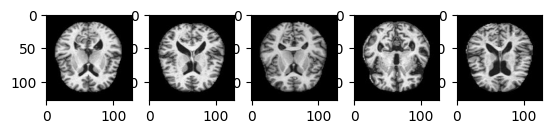

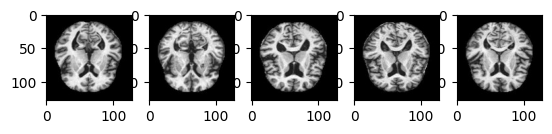

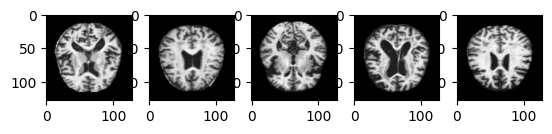

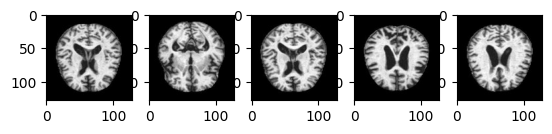

x train: (3840, 16384)
x validation: (1280, 16384)
x test: (1280, 16384)


In [3]:
# loading dataset 1
[x_train_0, y_train_0] = load_dataset("./Dataset1/Non_Demented", 0 )
[x_train_1, y_train_1] = load_dataset("./Dataset1/Very_Mild_Demented", 1)
[x_train_2, y_train_2] = load_dataset("./Dataset1/Mild_Demented", 2)
[x_train_3, y_train_3] = load_dataset("./Dataset1/Moderate_Demented", 3)

# print(X_train_1_1_1_0.shape, x_train_1.shape, x_train_2.shape, x_train_3.shape )



class_dict_1 = {"Non_Demented": y_train_0.shape[0], "Very_Mild_Demented": y_train_1.shape[0], "Mild_Demented": y_train_2.shape[0], "Moderate_Demented": y_train_3.shape[0]}


X = np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3 ))
Y = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3 ))


indices = np.random.choice(X.shape[0], size = X.shape[0], replace = False)
X = X[indices]
Y = Y[indices]


# print(X.shape, Y.shape)

X_train_1 = X[: int(X.shape[0] * 0.60)]
Y_train_1 = Y[: int(X.shape[0] * 0.60)]

X_val_1 = X[int(X.shape[0] * 0.60) : int(X.shape[0] * 0.80)]
Y_val_1 = Y[int(Y.shape[0] * 0.60) : int(Y.shape[0] * 0.80)]

X_test_1 = X[int(X.shape[0] * 0.80) : ]
Y_test_1 = Y[int(X.shape[0] * 0.80) : ]

print(f"x train: {X_train_1.shape}")
print(f"x validation: {X_val_1.shape}")
print(f"x test: {X_test_1.shape}")



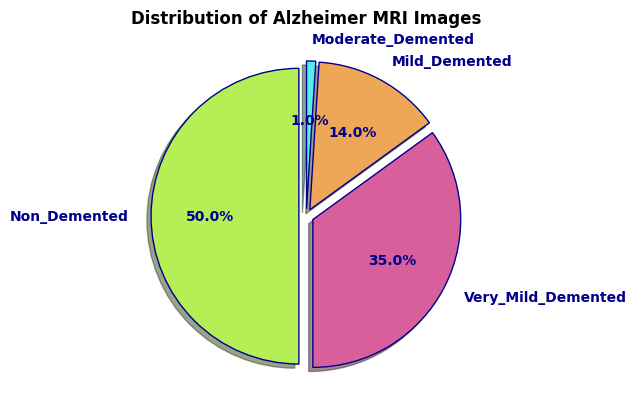

In [4]:
# pie chart for classes
def pie_chart(class_dict):
        colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
        keys = list(class_dict.keys())
        values = list(class_dict.values())
        explode = (0.05,)*len(keys)

        labels = [f'{key}' for key in keys]

        plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90, colors=colors, textprops={'fontsize': 10, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
                {'edgecolor':'darkblue'} , labeldistance=1.15)
        plt.title("Distribution of Alzheimer MRI Images", size=12, fontweight="bold")
pie_chart(class_dict_1)


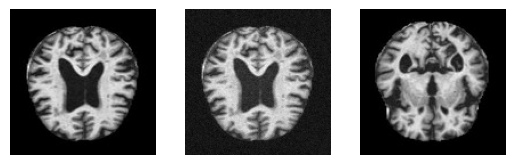

(5036, 16384)


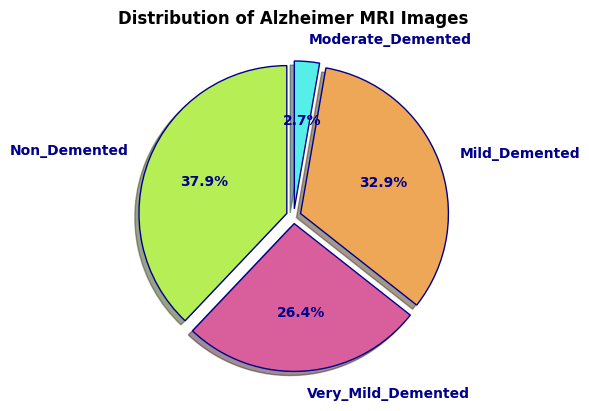

In [5]:

# Applying Data augumentation on the train set

def apply_brightness(image, max_delta=50):
    delta = np.random.randint(-max_delta, max_delta)
    bright_image = np.clip(image.astype(np.int16) + delta, 0, 255).astype(np.uint8)
    return bright_image

def add_gaussian_noise(image, mean=0, stddev=5):
    noise = np.random.normal(mean, stddev, image.shape).astype(np.float64)
    noisy_image = cv2.add(image, noise)
    return noisy_image

X_train_augmented = []
Y_train_augmented = []



for i in range(len(X_train_1)):
    image = X_train_1[i]
    y_image = Y_train_1[i]
    image= image.reshape((128, 128))
    image = image * 255

    if (y_image == 2 or y_image == 3):

        brightened_image = apply_brightness(image)
        X_train_augmented.append(brightened_image)
        Y_train_augmented.append(y_image)

        noisy_image = add_gaussian_noise(image)
        X_train_augmented.append(noisy_image)
        Y_train_augmented.append(y_image)

X_train_augmented = np.array(X_train_augmented)
Y_train_augmented = np.array(Y_train_augmented)


# printing the original image , brightened, image with added noise
rows = 1
cols = 3
for i in range(3):
    plt.subplot(rows, cols, i+1)
    plt.imshow(X_train_augmented[i], cmap='gray')
    plt.axis('off')
plt.show()

X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
X_train_augmented = X_train_augmented/255


X_train_1 = np.concatenate([X_train_augmented , X_train_1])
Y_train_1 = np.concatenate([Y_train_augmented , Y_train_1])



indices = np.random.choice(X_train_1.shape[0], size = X_train_1.shape[0], replace = False)
X_train_1 = X_train_1[indices]
Y_train_1 = Y_train_1[indices]
# print(X_train_1.shape)
# X_train_1 = X_train_1.reshape(X_train_1.shape[0], -1)
# X_train_1 = X_train_1 / 255

print(X_train_1.shape)

class_counts = dict(Counter(Y_train_1))
class_dict_1_augmented = {
    "Non_Demented": class_counts.get(0, 0),
    "Very_Mild_Demented": class_counts.get(1, 0),
    "Mild_Demented": class_counts.get(2, 0),
    "Moderate_Demented": class_counts.get(3, 0)
}
pie_chart(class_dict_1_augmented)




In [6]:

def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # 4 classes
    return model


In [7]:
model1 = cnn_model()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(X_train_1.shape)
num_classes = 4

Y_train_one_hot = to_categorical(Y_train_1, num_classes)
Y_val_one_hot = to_categorical(Y_val_1, num_classes)
Y_test_one_hot = to_categorical(Y_test_1, num_classes)

X_train_1 = X_train_1.reshape(-1, 128, 128, 1)
X_val_1 = X_val_1.reshape(-1, 128, 128, 1)
X_test_1 = X_test_1.reshape(-1, 128, 128, 1)

# 4. Train Model
history1 = model1.fit(X_train_1, Y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_val_1, Y_val_one_hot))

# 5. Evaluate Model
test_loss_1, test_acc_1 = model1.evaluate(X_test_1, Y_test_one_hot)
print('Test accuracy:', test_acc_1)

# 6. Predictions
predictions_1 = model1.predict(X_test_1)


(5036, 16384)
Epoch 1/10
158/158 [==============================] - 29s 178ms/step - loss: 0.9338 - accuracy: 0.5592 - val_loss: 0.8379 - val_accuracy: 0.6141
Epoch 2/10
158/158 [==============================] - 24s 149ms/step - loss: 0.5801 - accuracy: 0.7419 - val_loss: 0.7228 - val_accuracy: 0.6875
Epoch 3/10
158/158 [==============================] - 24s 154ms/step - loss: 0.3458 - accuracy: 0.8550 - val_loss: 0.4276 - val_accuracy: 0.8297
Epoch 4/10
158/158 [==============================] - 25s 158ms/step - loss: 0.2225 - accuracy: 0.9166 - val_loss: 0.4880 - val_accuracy: 0.7992
Epoch 5/10
158/158 [==============================] - 25s 158ms/step - loss: 0.1167 - accuracy: 0.9569 - val_loss: 0.2437 - val_accuracy: 0.9102
Epoch 6/10
158/158 [==============================] - 25s 160ms/step - loss: 0.0691 - accuracy: 0.9792 - val_loss: 0.2075 - val_accuracy: 0.9414
Epoch 7/10
158/158 [==============================] - 27s 168ms/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0

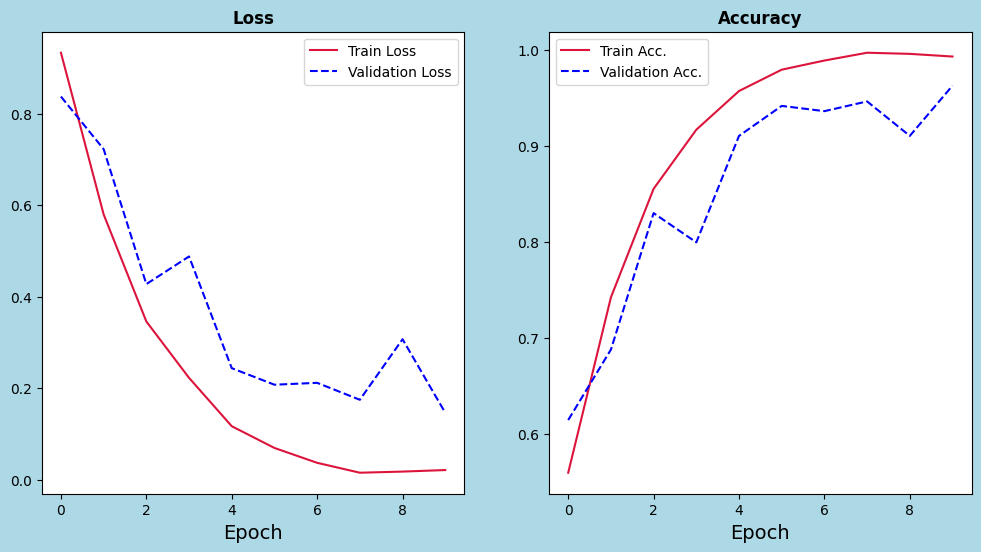

In [8]:
# evaluation metric for two datasets

fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="lightblue")
ax[0].set_facecolor('white')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history1.epoch, history1.history["loss"], label="Train Loss", color="crimson")
ax[0].plot(history1.epoch, history1.history["val_loss"], label="Validation Loss", color="blue", linestyle="--")
ax[0].legend()
ax[1].set_facecolor('white')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history1.epoch, history1.history["accuracy"], label="Train Acc.", color="crimson")
ax[1].plot(history1.epoch, history1.history["val_accuracy"], label="Validation Acc.", color="blue", linestyle="--")
ax[1].legend()
plt.show()



In [9]:

predicted_labels_1 = np.argmax(predictions_1, axis=1)

# Print classification report
print(classification_report(Y_test_1, predicted_labels_1))

Y_test_one_hot = to_categorical(Y_val_1, 4)
test_loss_2, test_acc_2 = model1.evaluate(X_val_1, Y_test_one_hot)
print('Test accuracy:', test_acc_2)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       649
           1       0.94      0.94      0.94       457
           2       0.94      0.94      0.94       163
           3       1.00      1.00      1.00        11

    accuracy                           0.96      1280
   macro avg       0.96      0.96      0.96      1280
weighted avg       0.96      0.96      0.96      1280

40/40 [==============================] - 2s 55ms/step - loss: 0.1462 - accuracy: 0.9625
Test accuracy: 0.9624999761581421


(5036, 16384)


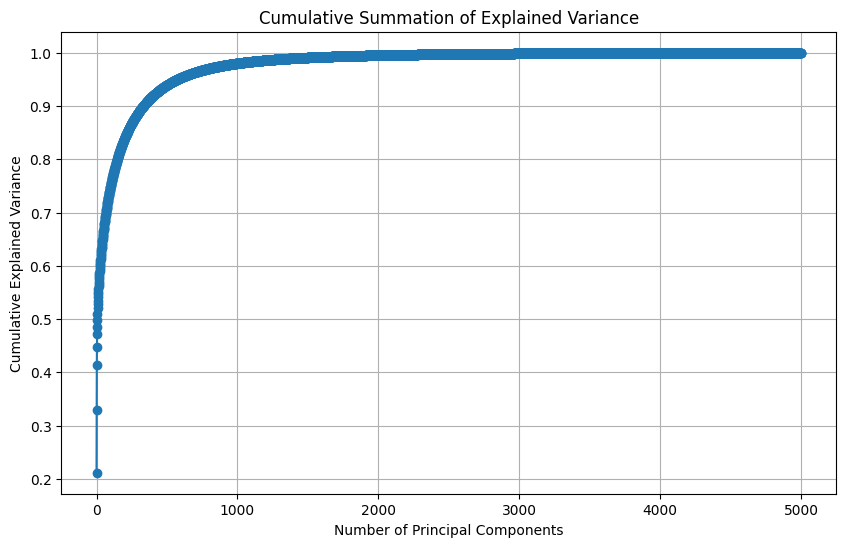

In [11]:
# graph of cummulative explained variance VS no of dimensions to be taken for PCA
X_train_1= X_train_1.reshape((X_train_1.shape[0], -1))
X_test_1= X_test_1.reshape((X_test_1.shape[0], -1))
X_val_1= X_val_1.reshape((X_val_1.shape[0], -1))

print(X_train_1.shape)
pca = PCA(n_components=5000)
pca.fit(X_train_1)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Summation of Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [12]:
#  PCA for the dataset
def calculate_pca(X_train, X_test, X_val, p):

    pca = PCA(n_components=p)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_val_pca = pca.transform(X_val)

    # applying QDA to find thhe accuracy corresponding to the dimensionality reduction

    # qda = QuadraticDiscriminantAnalysis()
    # qda.fit(X_train_pca, Y_train)

    # # Calculate the accuracy
    # accuracy = qda.score(X_test_pca, Y_test)
    # print("Accuracy after QDA on dimensionaly reduced dataset:", accuracy)
    return X_train_pca, X_test_pca, X_val_pca

#  taking PCA (p= 100), as it is the closest to the total accuracy without dimensional reduction


X_train_1 , X_test_1, X_val_1= calculate_pca(X_train_1, X_test_1, X_val_1, 1500)
X_train_1 , X_test_1, X_val_1= calculate_pca(X_train_1, X_test_1, X_val_1, 1500)
print(X_train_1.shape)
print(X_val_1.shape)
print(X_test_1.shape)



(5036, 1500)
(1280, 1500)
(1280, 1500)


In [13]:
X_train = X_train_1
Y_train = Y_train_1

X_val = X_val_1
Y_val = Y_val_1

X_test = X_test_1
Y_test = Y_test_1
def find_class_accuracies(y_pred):
    classwise_correct_predicted_samples = [0] * 4
    classwise_total_samples = [0] * 4
    for i in range(Y_test.shape[0]):
        y = Y_test[i]
        classwise_total_samples[y]+=1
        if (y == y_pred[i]):
            classwise_correct_predicted_samples[y] +=1

    accuracies = [0] * 4
    for i in range(4):
        accuracies[i]= classwise_correct_predicted_samples[i] / classwise_total_samples[i]


    print(f"Accuracy of Non demented: {accuracies[0]}")
    print(f"Accuracy of Very Mild demented: {accuracies[1]}")
    print(f"Accuracy of Mild demented: {accuracies[2]}")
    print(f"Accuracy of Moderate demented: {accuracies[3]}")


Validation Accuracy:  0.946875
Test accuracy:  0.94609375
Accuracy of Non demented: 0.9645608628659477
Accuracy of Very Mild demented: 0.9190371991247265
Accuracy of Mild demented: 0.9447852760736196
Accuracy of Moderate demented: 1.0


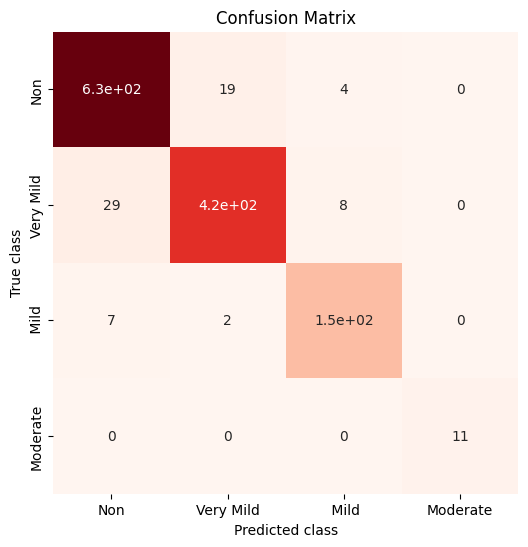

In [14]:
# Model1: Multiclass Logistic Regression

log_reg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', max_iter=2000)
log_reg.fit(X_train, Y_train)

validation_accuracy = log_reg.score(X_val, Y_val)
print("Validation Accuracy: ", validation_accuracy)

test_accuracy = log_reg.score(X_test, Y_test)
print("Test accuracy: ", test_accuracy)
y_pred = log_reg.predict(X_test)
find_class_accuracies(y_pred)


# for the test set calculaitng the recall = no of true positives / total no of positives = no of true positives / no of true positives + no of false negatives

conf_matrix = confusion_matrix(Y_test, y_pred)

classes =['Non', 'Very Mild', ' Mild', 'Moderate' ]
plt.figure(figsize = (6,6), facecolor=(1,1,1,0))
sns.heatmap(conf_matrix, annot=True, cmap = 'Reds', cbar = False,xticklabels=classes , yticklabels=classes)

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# considering very-mild, mild and moderate to be positive and non-demented to be negative
def print_confusion_matrix(model):
    Y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(Y_test, Y_pred)

    total_negative = np.sum(conf_matrix[0])
    total_positive = Y_test.shape[0] - total_negative
    tn = conf_matrix[0][0] / total_negative
    fn = (conf_matrix[1][0] + conf_matrix[2][0] + conf_matrix[3][0]) / total_negative
    fp = (conf_matrix[0][1] + conf_matrix[0][2] + conf_matrix[0][3]) / total_positive
    tp = 0

    for i in range(1,4):
        for j in range(1,4):
            tp += conf_matrix[i][j]
    tp = tp / total_positive

    plt.figure(figsize=(6,6))
    categories = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = [tn, fp, fn, tp]


    plt.bar(categories ,counts, color = ['Red', 'Blue', 'Yellow', 'Green'])
    plt.xlabel('Categories')
    plt.ylabel('Samples')
    plt.show()

100
Validation Accuracy:  0.62265625
Test accuracy:  0.64140625
Accuracy of Non demented: 0.7041602465331279
Accuracy of Very Mild demented: 0.6017505470459519
Accuracy of Mild demented: 0.5214723926380368
Accuracy of Moderate demented: 0.36363636363636365


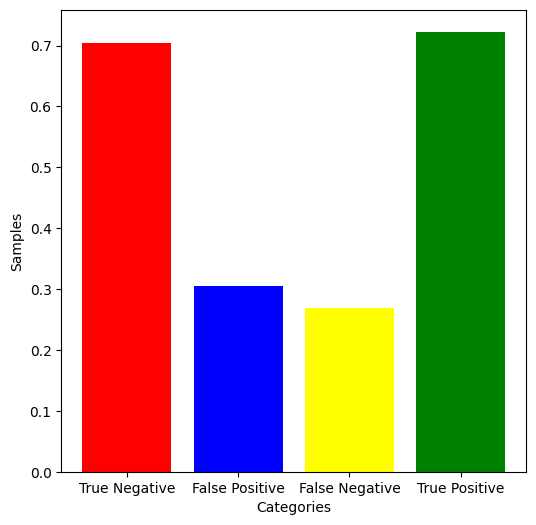

In [16]:
# decision tree model - used cross validation to get the max depth to be choosen

param_grid = {'max_depth': [25, 50 , 100]}
decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')  # cross validation
grid_search.fit(X_train, Y_train)

best_depth = grid_search.best_params_['max_depth']
print(best_depth)

best_decision_tree = grid_search.best_estimator_

validation_accuracy = best_decision_tree.score(X_val, Y_val)
print("Validation Accuracy: ", validation_accuracy)

test_accuracy = best_decision_tree.score(X_test, Y_test)
print("Test accuracy: ", test_accuracy)
y_pred = best_decision_tree.predict(X_test)
find_class_accuracies(y_pred)
print_confusion_matrix(grid_search)



Test Accuracy:  0.8515625
Accuracy of Non demented: 0.9969183359013868
Accuracy of Very Mild demented: 0.7221006564551422
Accuracy of Mild demented: 0.6871165644171779
Accuracy of Moderate demented: 0.09090909090909091


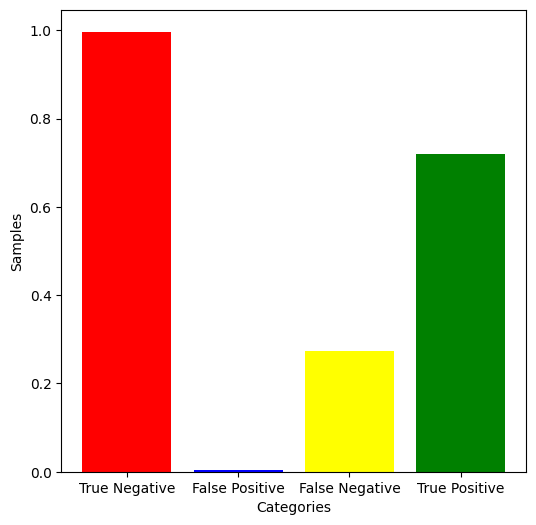

In [17]:
# random forest
X_combined = np.concatenate((X_train, X_val))
Y_combined = np.concatenate((Y_train, Y_val))

random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_combined, Y_combined)

test_accuracy = random_forest.score(X_test, Y_test)
print("Test Accuracy: ", test_accuracy)
y_pred = random_forest.predict(X_test)
find_class_accuracies(y_pred)
print_confusion_matrix(random_forest)
